In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.2 MB/s eta 0:00:00


In [ ]:
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf

def load_image(path):
  image = tf.io.read_file(path)
  # Add your preprocessing steps here (e.g., normalization, resizing)
  image = tf.image.decode_jpeg(image, channels=3)  # Assuming JPGs
  image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
  image = tf.image.resize(image, (28,28))

  # Resize to desired size (replace with your dimensions)

  return image

# Assuming downloaded images are in a folder named "downloaded_images" on your local machine
image_paths = tf.io.gfile.glob("/content/drive/MyDrive/airplane/*.jpg")
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_image)


In [ ]:
ds=dataset

In [ ]:

ds = ds.batch(128)

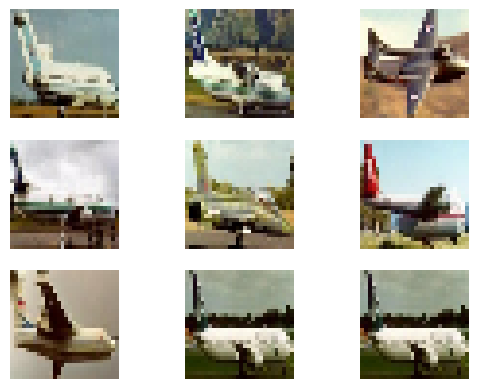

In [ ]:
# prompt: display sAMPLE IMAGES

import matplotlib.pyplot as plt

# Assuming 'ds' is your batched dataset
for images in ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")
plt.show()


In [ ]:
images[9].shape

TensorShape([28, 28, 3])

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
import numpy as np


In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(3, 4, padding='same', activation='tanh'))

    return model

In [ ]:

generator = build_generator()


In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 1s 604ms/step


In [ ]:
img.shape

(4, 28, 28, 3)

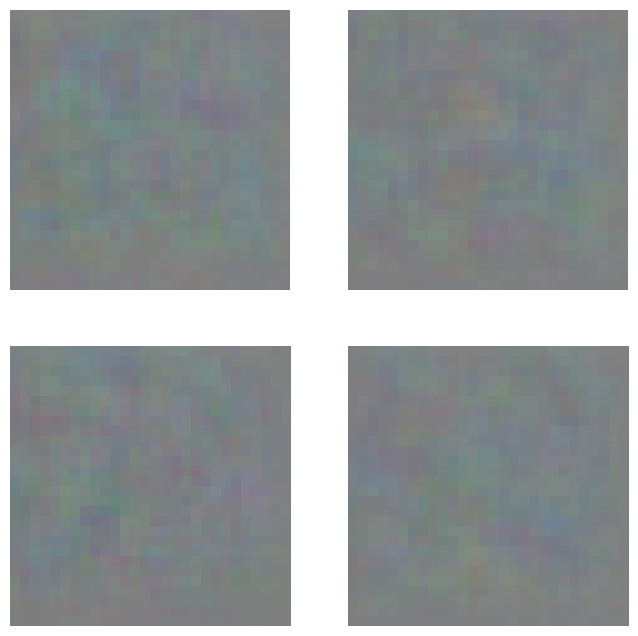

In [ ]:
# prompt: display the img generated

# Assuming 'img' contains the generated images
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow((img[i] + 1) / 2)  # Rescale to [0, 1] for display
    plt.axis('off')
plt.show()


In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:


discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
discriminator.predict(img)


1/1 [==============================] - 0s 239ms/step


array([[0.5016851 ],
       [0.50108266],
       [0.5009672 ],
       [0.498956  ]], dtype=float32)

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
                        # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:

#  subclassed model
gan = GAN(generator, discriminator)

In [ ]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:


import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))


In [ ]:
import os

# Create the 'images' directory if it doesn't exist
os.makedirs('images', exist_ok=True)


In [ ]:
hist = gan.fit(ds, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50
1/1 [==============================] - 30s 30s/step - d_loss: 0.6980 - g_loss: 0.6929
Epoch 2/50
1/1 [==============================] - 30s 30s/step - d_loss: 0.6962 - g_loss: 0.6888
Epoch 3/50
1/1 [==============================] - 28s 28s/step - d_loss: 0.6998 - g_loss: 0.6853
Epoch 4/50
1/1 [==============================] - 29s 29s/step - d_loss: 0.6951 - g_loss: 0.6829
Epoch 5/50
1/1 [==============================] - 29s 29s/step - d_loss: 0.7026 - g_loss: 0.6829
Epoch 6/50
1/1 [==============================] - 30s 30s/step - d_loss: 0.6997 - g_loss: 0.6860
Epoch 7/50
1/1 [==============================] - 33s 33s/step - d_loss: 0.6943 - g_loss: 0.6917
Epoch 8/50
1/1 [==============================] - 30s 30s/step - d_loss: 0.6962 - g_loss: 0.6987
Epoch 9/50
1/1 [==============================] - 30s 30s/step - d_loss: 0.6756 - g_loss: 0.7107
Epoch 10/50
1/1 [==============================] - 29s 29s/step - d_loss: 0.6720 - g_loss: 0.7246
Epoch 11/50
1/1 [============

In [ ]:
# prompt: NotImplementedError                       Traceback (most recent call last)
# <ipython-input-29-d3fdf2a9b884> in <cell line: 4>()
#       2
#       3 # Assuming 'gan' is your trained GAN model
# ----> 4 gan.save("gan_model.h5")
# 1 frames
# /usr/local/lib/python3.10/dist-packages/keras/src/saving/legacy/save.py in save_model(model, filepath, overwrite, include_optimizer, save_format, signatures, options, sa
generator.save_weights('ganmodel.h5')


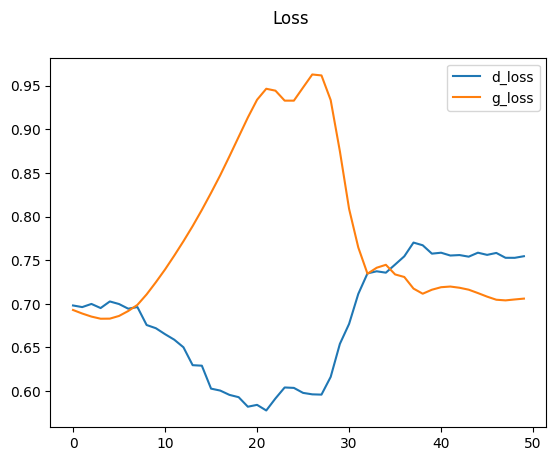

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
generator.load_weights('ganmodel.h5')

In [ ]:
imgs1 = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 1s 665ms/step


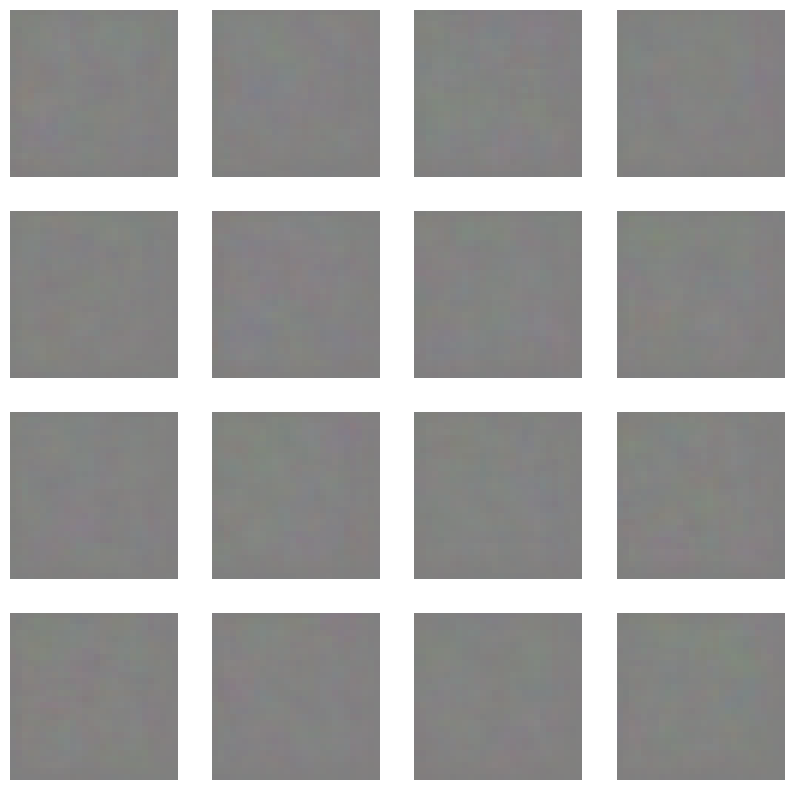

In [ ]:
# prompt: now
# show all
# the generated images

# Rescale images to the range [0, 1] for display
imgs1 = (imgs1 + 1) / 2

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(imgs1.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs1[i])
    plt.axis('off')
plt.show()


In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
